In [ ]:
''' Identify important content-level video features for each pipeline.
Challenge: 1. many features are highly correlated. how to reduce redundancy.
           2. identify "all" important features.
           
High-level description of our feature selection (two steps):
            1. Remove highly correlated features.
            2. Identify important features using different kinds of feature selection methods.
'''

In [1]:
import os
from collections import defaultdict
import glob
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge, 
								  Lasso)
from sklearn import preprocessing
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from minepy import MINE
import operator
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
from pipeline_performance_loader import Parser, initialization, read_feature
from sklearn.base import BaseEstimator, TransformerMixin
from VIF import ReduceVIF
import seaborn as sns

In [2]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))


def rank_to_dict(ranks, names, order=1):
#     minmax = MinMaxScaler()
#     ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def topK_index(data, K):
    indices = data.argsort()[-1*K:][::-1]
    return indices, data[indices]

In [3]:
def feature_filtering(df, filter_method='pearson'):
	# remove correlated features
	if filter_method == 'VIF':
		# filter 
		transformer = ReduceVIF(thresh=5)
		df_filtered = transformer.fit_transform(df)
		return df_filtered
	elif filter_method == 'pearson':
		# filter feateures with pearson correlation higher than a thresh
		corr_matrix = df.corr()
		correlated_features = set()
		thresh = 0.8
		for i in range(len(corr_matrix.columns)):
			for j in range(i):
				if abs(corr_matrix.iloc[i, j]) > thresh:
					colname = corr_matrix.columns[i]
					correlated_features.add(colname)
		df_filtered = df.drop(correlated_features, axis=1)
		return df_filtered

	
	else:
		print('Filter method {} does not exist.'.format(filter_method))
		return df

In [4]:
# Load pipeline performance
all_feature_names, moving, video_to_delete, selected_video, glimpse_video_to_delete = initialization()
path = '/Users/zhujunxiao/Desktop/benchmarking/vldb/data/'
feature_file = path + 'allvideo_features_long.csv'#'features_all_type_width_height_filter.csv'
features = read_feature(feature_file)

videostorm_path = path + 'videostorm/overfitting_results/'
videostorm_parser = Parser('videostorm', 
                          videostorm_path)
videostorm_perf = videostorm_parser.load_perf()




In [5]:
target_perf = videostorm_perf
NUM_OF_FEATURES=2

In [6]:

X = []
y = []

for key in sorted(target_perf.keys()):
    if key not in features:
        continue

    # data cleaning
    if features[key][all_feature_names.index('object_cn_median')] < 1:
        continue
    if features[key][all_feature_names.index('velocity_avg')] < 1:
        continue
    if features[key][all_feature_names.index('object_size_avg')] <= 0:
        continue

    thresh1 = 0.05		
    if np.abs(target_perf[key][1] - 0.9) > thresh1:
        continue
    X.append(features[key])
    y.append(target_perf[key][0])

# preprocessing: standardization, and train test split
print('Preprocessing starts (normalization, train_test_split)......')
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)  
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                    test_size=0.2, random_state=0) 

print('Preprocessing done!')

Preprocessing starts (normalization, train_test_split)......
Preprocessing done!


After pearson correlation filtering, remaining features: Index(['object_cn_median', 'object_cn_var', 'object_cn_skewness',
       'object_cn_kurtosis', 'object_cn_entropy', 'object_size_median',
       'object_size_avg', 'object_size_mode', 'object_size_var',
       'object_size_skewness', 'object_size_percentile5',
       'arrival_rate_median', 'arrival_rate_var', 'arrival_rate_skewness',
       'arrival_rate_entropy', 'velocity_median', 'velocity_mode',
       'velocity_skewness', 'total_area_median', 'total_area_mode',
       'total_area_skewness', 'number_of_object_classes'],
      dtype='object')
ReduceVIF fit
ReduceVIF transform


/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping object_cn_var with vif=inf
Dropping object_cn_percentile25 with vif=inf
Dropping object_size_var with vif=inf
Dropping object_size_percentile25 with vif=inf
Dropping arrival_rate_var with vif=inf
Dropping arrival_rate_percentile25 with vif=inf
Dropping velocity_var with vif=inf
Dropping velocity_percentile25 with vif=inf
Dropping total_area_var with vif=inf
Dropping total_area_percentile25 with vif=inf
Dropping velocity_avg with vif=5139.052540440993
Dropping total_area_avg with vif=4657.320153048992
Dropping velocity_percentile75 with vif=1931.144711237196
Dropping arrival_rate_avg with vif=1079.691329643382
Dropping object_cn_avg with vif=745.2444808020844
Dropping object_size_percentile75 with vif=591.702472040522
Dropping object_size_avg with vif=334.74199501602436
Dropping total_area_percentile75 with vif=268.54759103699337
Dropping arrival_rate_percentile75 with vif=250.78328334018377
Dropping velocity_entropy with vif=182.89408008259142
Dropping object_cn_percentile75 w

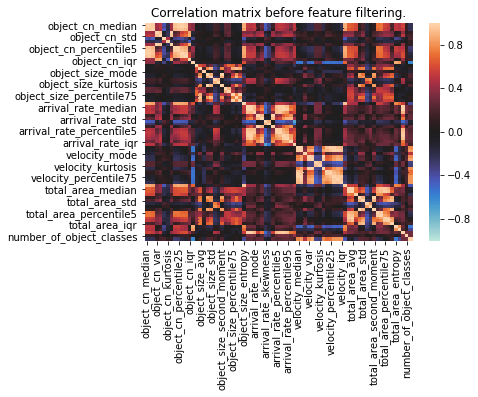

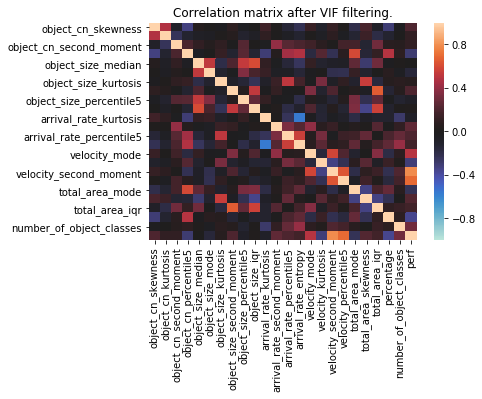

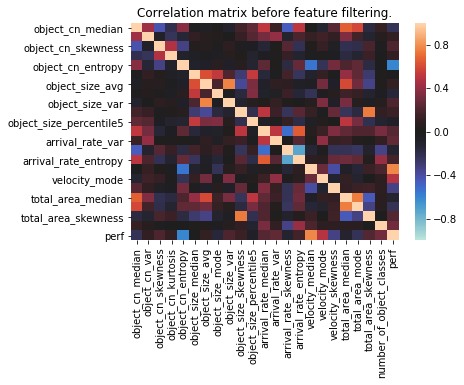

In [7]:
# remove correlated features, using two methods
df = pd.DataFrame(X_train, columns=all_feature_names)
df_filtered_pearson = feature_filtering(df)
print('After pearson correlation filtering, remaining features:', df_filtered_pearson.columns)
df_filtered_vif = feature_filtering(df, filter_method='VIF')
print('After VIF filtering, remaining features:', df_filtered_vif.columns)

# visualize correlation matrix before and after filtering
df['perf'] = y_train
df_filtered_pearson['perf'] = y_train
df_filtered_vif['perf'] = y_train

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
cor = df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()
cor = df_filtered_vif.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix after VIF filtering.')
plt.show()
cor = df_filtered_pearson.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()	


In [8]:
# Implement multiple types of feature selection methods. And compare their selected results.

def select_good_features(X, Y, names, n_features_to_select=5):
    ranks = {}
    lr = LinearRegression(normalize=True)
    lr.fit(X, Y)
    ranks["Linear"] = rank_to_dict(np.abs(lr.coef_), names)

    ridge = Ridge(alpha=7)
    ridge.fit(X, Y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)


    lasso = Lasso(alpha=.05)
    lasso.fit(X, Y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)


    #stop the search when 5 features are left (they will get equal scores)
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X,Y)
    ranks["RFE"] = rank_to_dict(rfe.ranking_, names, order=-1)

    rf = RandomForestRegressor()
    rf.fit(X,Y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


    f, pval  = f_regression(X, Y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)

    mine = MINE()
    mic_scores = []
    for i in range(X.shape[1]):
        mine.compute_score(X[:,i], Y)
        m = mine.mic()
        mic_scores.append(m)

    ranks["MIC"] = rank_to_dict(mic_scores, names) 
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

  

    # rank = [np.abs(x) for x in lr.feature_importances_]
    # indicies = topK_index(np.asarray(rank), 3)

    # for i in indicies[0]:
    # 	print(all_feature_names[i])

    return methods, ranks





In [9]:
features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


The shape of feature matrix: (471, 73)
all feature names: ['object_cn_median' 'object_cn_avg' 'object_cn_mode' 'object_cn_var'
 'object_cn_std' 'object_cn_skewness' 'object_cn_kurtosis'
 'object_cn_second_moment' 'object_cn_percentile5'
 'object_cn_percentile25' 'object_cn_percentile75'
 'object_cn_percentile95' 'object_cn_iqr' 'object_cn_entropy'
 'object_size_median' 'object_size_avg' 'object_size_mode'
 'object_size_var' 'object_size_std' 'object_size_skewness'
 'object_size_kurtosis' 'object_size_second_moment'
 'object_size_percentile5' 'object_size_percentile25'
 'object_size_percentile75' 'object_size_percentile95' 'object_size_iqr'
 'object_size_entropy' 'arrival_rate_median' 'arrival_rate_avg'
 'arrival_rate_mode' 'arrival_rate_var' 'arrival_rate_std'
 'arrival_rate_skewness' 'arrival_rate_kurtosis'
 'arrival_rate_second_moment' 'arrival_rate_percentile5'
 'arrival_rate_percentile25' 'arrival_rate_percentile75'
 'arrival_rate_percentile95' 'arrival_rate_iqr' 'arrival_rate_entr

In [10]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	26.54	0.0	0.02	0.22	0.0	13	0.01	5.68
                 object_cn_avg	23.87	0.0	0.03	0.23	0.0	57	0.0	11.59
                object_cn_mode	27.24	0.0	0.01	0.21	0.0	18	0.0	6.49
                 object_cn_var	5.62	0.0	196182745613.78	0.29	0.0	23	0.0	28026106520.38
                 object_cn_std	13.31	0.0	0.01	0.29	0.0	22	0.0	5.09
            object_cn_skewness	21.56	0.0	0.0	0.18	0.0	48	0.0	9.96
            object_cn_kurtosis	5.26	0.0	0.0	0.16	0.0	59	0.0	9.2
       object_cn_second_moment	5.62	0.0	196182745613.78	0.29	0.0	36	0.0	28026106522.24
         object_cn_percentile5	43.86	0.0	0.0	0.24	0.0	53	0.0	13.87
        object_cn_percentile25	37.42	0.0	58811370067.28	0.24	0.0	49	0.0	8401624307.71
        object_cn_percentile75	15.01	0.0	69276401365.29	0.24	0.0	20	0.0	9896628771.51
        object_cn_percentile95	8.39	0.0	0.0	0.23	0.0	65	0.0	10.52
                 object_cn_iqr	10.9	0.0	244394535

In [11]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)


Selected features of method Corr.:
velocity_std 1363.66
velocity_avg 1063.14
velocity_iqr 988.08
Selected features of method Lasso:
velocity_std 0.03
velocity_avg 0.01
object_cn_median 0.0
Selected features of method Linear:
object_size_percentile75 215730669655.27
object_size_iqr 200227539606.56
object_cn_var 196182745613.78
Selected features of method MIC:
velocity_avg 0.86
velocity_percentile75 0.8
velocity_percentile95 0.8
Selected features of method RF:
velocity_avg 0.4
velocity_percentile95 0.31
velocity_second_moment 0.06
Selected features of method RFE:
percentage 69
total_area_skewness 68
velocity_mode 67
Selected features of method Ridge:
velocity_std 0.04
velocity_entropy 0.03
velocity_skewness 0.02
Selected features of method Mean:
object_size_percentile75 30818667098.97
object_size_iqr 28603934236.89
object_cn_second_moment 28026106522.24


In [12]:
features = df_filtered_pearson.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_pearson['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (471, 22)
all feature names: ['object_cn_median' 'object_cn_var' 'object_cn_skewness'
 'object_cn_kurtosis' 'object_cn_entropy' 'object_size_median'
 'object_size_avg' 'object_size_mode' 'object_size_var'
 'object_size_skewness' 'object_size_percentile5' 'arrival_rate_median'
 'arrival_rate_var' 'arrival_rate_skewness' 'arrival_rate_entropy'
 'velocity_median' 'velocity_mode' 'velocity_skewness' 'total_area_median'
 'total_area_mode' 'total_area_skewness' 'number_of_object_classes']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [13]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	26.54	0.0	0.05	0.22	0.01	1	0.04	3.98
                 object_cn_var	5.62	0.0	0.0	0.29	0.01	18	0.0	3.42
            object_cn_skewness	21.56	0.0	0.0	0.18	0.01	15	0.0	5.25
            object_cn_kurtosis	5.26	0.0	0.01	0.16	0.01	12	0.01	2.49
             object_cn_entropy	260.96	0.0	0.02	0.5	0.02	1	0.02	37.5
            object_size_median	0.0	0.0	0.01	0.29	0.01	9	0.01	1.33
               object_size_avg	6.33	0.0	0.01	0.24	0.01	10	0.0	2.37
              object_size_mode	10.37	0.0	0.0	0.28	0.01	17	0.0	3.95
               object_size_var	21.43	0.0	0.0	0.22	0.01	14	0.0	5.09
          object_size_skewness	8.5	0.0	0.01	0.26	0.01	6	0.01	2.11
       object_size_percentile5	2.53	0.0	0.0	0.2	0.01	16	0.0	2.68
           arrival_rate_median	27.08	0.0	0.04	0.22	0.02	1	0.03	4.06
              arrival_rate_var	34.49	0.0	0.0	0.32	0.03	13	0.0	6.83
         arrival_rate_skewness	6.4	0.0	0.0	0.18	0.01	8	0.0

In [14]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
velocity_median 708.01
object_cn_entropy 260.96
velocity_mode 153.19
Selected features of method Lasso:
velocity_median 0.02
object_cn_median 0.0
object_cn_var 0.0
Selected features of method Linear:
object_cn_median 0.05
velocity_median 0.05
arrival_rate_median 0.04
Selected features of method MIC:
velocity_median 0.74
velocity_mode 0.71
object_cn_entropy 0.5
Selected features of method RF:
velocity_mode 0.39
velocity_median 0.36
velocity_skewness 0.04
Selected features of method RFE:
object_cn_var 18
object_size_mode 17
object_size_percentile5 16
Selected features of method Ridge:
velocity_median 0.05
object_cn_median 0.04
arrival_rate_median 0.03
Selected features of method Mean:
velocity_median 101.46
object_cn_entropy 37.5
velocity_mode 22.47


In [15]:
features = df_filtered_vif.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_vif['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (471, 23)
all feature names: ['object_cn_skewness' 'object_cn_kurtosis' 'object_cn_second_moment'
 'object_cn_percentile5' 'object_size_median' 'object_size_mode'
 'object_size_kurtosis' 'object_size_second_moment'
 'object_size_percentile5' 'object_size_iqr' 'arrival_rate_kurtosis'
 'arrival_rate_second_moment' 'arrival_rate_percentile5'
 'arrival_rate_entropy' 'velocity_mode' 'velocity_kurtosis'
 'velocity_second_moment' 'velocity_percentile5' 'total_area_mode'
 'total_area_skewness' 'total_area_iqr' 'percentage'
 'number_of_object_classes']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [16]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
            object_cn_skewness	21.56	0.0	0.0	0.18	0.0	14	0.0	5.11
            object_cn_kurtosis	5.26	0.0	0.01	0.16	0.0	9	0.01	2.06
       object_cn_second_moment	5.62	0.0	0.0	0.29	0.01	13	0.0	2.7
         object_cn_percentile5	43.86	0.0	0.03	0.24	0.0	1	0.03	6.45
            object_size_median	0.0	0.0	0.01	0.29	0.01	4	0.01	0.62
              object_size_mode	10.37	0.0	0.0	0.28	0.01	16	0.0	3.81
          object_size_kurtosis	1.53	0.0	0.01	0.26	0.01	6	0.01	1.12
     object_size_second_moment	21.43	0.0	0.0	0.22	0.01	17	0.0	5.52
       object_size_percentile5	2.53	0.0	0.0	0.2	0.0	15	0.0	2.53
               object_size_iqr	0.45	0.0	0.01	0.23	0.01	10	0.01	1.53
         arrival_rate_kurtosis	2.82	0.0	0.0	0.18	0.0	19	0.0	3.14
    arrival_rate_second_moment	34.49	0.0	0.01	0.32	0.01	5	0.01	5.69
      arrival_rate_percentile5	21.23	0.0	0.03	0.25	0.0	1	0.03	3.22
          arrival_rate_entropy	13.35	0.0	0.01	0.31	0.01	1	0.01	2.

In [17]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
velocity_second_moment 807.39
velocity_percentile5 447.32
velocity_mode 153.19
Selected features of method Lasso:
velocity_second_moment 0.03
object_cn_skewness 0.0
object_cn_kurtosis 0.0
Selected features of method Linear:
velocity_second_moment 0.04
velocity_percentile5 0.04
object_cn_percentile5 0.03
Selected features of method MIC:
velocity_mode 0.71
velocity_second_moment 0.71
velocity_percentile5 0.69
Selected features of method RF:
velocity_second_moment 0.72
velocity_percentile5 0.11
velocity_kurtosis 0.04
Selected features of method RFE:
arrival_rate_kurtosis 19
velocity_mode 18
object_size_second_moment 17
Selected features of method Ridge:
velocity_second_moment 0.04
object_cn_percentile5 0.03
arrival_rate_percentile5 0.03
Selected features of method Mean:
velocity_second_moment 115.7
velocity_percentile5 64.17
velocity_mode 24.56


In [18]:
from scipy.stats import pearsonr

features = df.drop(['perf'], axis=1)
X = features.values
Y = df['perf']
names = features.columns.values
correlation_thresh = 0.5
correlated_features = []
for name in names:
    (r, p) = pearsonr(df[name], df['perf'])
    if np.abs(r) > correlation_thresh:
        correlated_features.append((name,r))
        print(name, r)
correlated_features.sort(key=lambda x: x[1], reverse=True)
selected_features = [correlated_features[0][0]]
for feature in correlated_features[1:]:
    (r, p) = pearsonr(df[feature[0]], df[correlated_features[0][0]])
    if np.abs(r) <= 0.5:
        selected_features.append(feature[0])
print('Final selected feature:', selected_features)

velocity_avg 0.8832379766425966
velocity_iqr 0.8678166760951062
velocity_percentile75 0.8428790541375415
velocity_percentile95 0.8958572371347294
velocity_var 0.9715577102522532
velocity_second_moment 0.9715577102522532
velocity_median 0.7851949958821947
velocity_percentile25 0.7152519950336248
velocity_percentile5 0.6681088594964711
total_area_entropy -0.500863004642276
object_cn_entropy -0.52658759477639
Final selected feature: ['velocity_std']
